In [1]:
from pandas import DataFrame, Series
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter
CONTROL_GROUP = 0
CONTROL_COLOR ='blue'
TEST_GROUP = 1
TEST_COLOR = 'green'
GROUP_DICT = {0: 'Control', 1: 'Test'}

In [2]:
#Data Loading
customer_df = pd.read_csv('testSamples.csv', index_col='sample_id')
trans_df = pd.read_csv('transData.csv', index_col='transaction_id')

In [3]:
#Sanity Check
print(customer_df['test_group'].unique())
print(trans_df['transaction_type'].unique())

[0 1]
['REBILL' 'CHARGEBACK' 'REFUND']


## Premilinary consideration

- In the uncertainty of the target audience of this reports, I assume a basic stats knowledge from the reader. I hope that it was what I was supposed to do.
- For me it was unclear wath I was supposed to do with de cutomer that does not have any recorded transaction. I decided to removed them from the dataset for question 2,3,4 about transactional behaviour. This would be a good choice if for example they where randomized recently and we did not have the time to get transaction information about them. With more context, I should have take anothe decision.

## Question 1

What is the aproximate probability distribution between the test group and the control group

In [4]:
pvalue = 0.05
conf_int = stats.bayes_mvs(customer_df['test_group'],1-pvalue)[0]
conf_int

Mean(statistic=0.24840508363892097, minmax=(0.2449396569789553, 0.25187051029888663))

In [5]:
conf_int[0]-conf_int[1][0] #error margin

0.003465426659965659

Since the group attribuation is made following an unbalanced coins flip, it follows a Bernouilli distrubution wiht probability $p$ of being in the test group. The probability $p$ is given by the expoected value of the distribution. Therefore the parameter $p$ of the distibution is $0.2484 \pm 0.0035$, $95\%$ of the time.

## Question 2: 
__Is a user that must call-in to cancel more likely to generate at least 1 addition REBILL?__

In [6]:
trans_df['is_rebill'] = (trans_df['transaction_type'] == 'REBILL')

In [7]:
customer_df['have_rebill'] = trans_df[['sample_id', 'is_rebill']].groupby(['sample_id']).any()
customer_df.dropna(inplace=True) #User with no transaction are removed from the customer table

In [8]:
contigency_table = customer_df.groupby(['test_group', 'have_rebill']).size().unstack()
contigency_table.rename(columns={False: 'No', True: 'Yes'}, index=GROUP_DICT, inplace=True)
contigency_table

have_rebill,No,Yes
test_group,,
Control,138,941
Test,79,1556


In [9]:
stats.chi2_contingency(contigency_table)

(54.88098606287686,
 1.2805387468455995e-13,
 1,
 array([[  86.27229182,  992.72770818],
        [ 130.72770818, 1504.27229182]]))

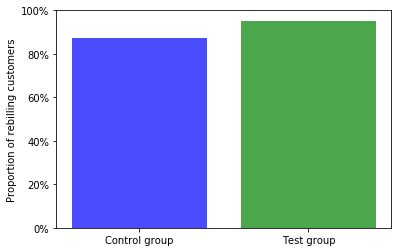

In [10]:
fig, ax = plt.subplots()
ypos = [1,2]
plt.bar(ypos, contigency_table['Yes']/contigency_table.sum(axis=1), align='center', alpha=0.7, 
        color=[CONTROL_COLOR, TEST_COLOR])
plt.xticks(ypos, ['Control group', 'Test group'])
plt.ylabel('Proportion of rebilling customers')
ax.yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

__ANSWER:__
A user that need to call in much more likelly to make at least one rebill operation. We first  determine using the transactions datat if a user as conduct a rebill transaction. A user with no transaction is considered as a user with no rebill transaction. We conduct à chi squared test to test the indepedance between the group attribution and the likelohood of making a  rebill transaction. The outcome is a p-value of almost zero. Therefore with very high probability being required to cancel by phone impact the likeklihood et rebilling. Since the proportion of rebilling is much higer in the test group (see the plot above), requiring to call for cancelling increase the chances of seeing a rebill transaction.

## Question 3
__Is a user that must call-in to cancel more likely to generate more revenues?__

In [11]:
#Add the revenue generated by each customer to the customer df
customer_df['generated_revenue'] = trans_df[['sample_id', 'transaction_amount']].groupby('sample_id').sum()

In [12]:
test_rev = customer_df.loc[customer_df['test_group']==TEST_GROUP, 'generated_revenue']
ctrl_rev = customer_df.loc[customer_df['test_group']==CONTROL_GROUP, 'generated_revenue']

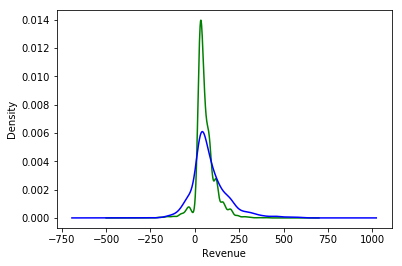

In [13]:
test_rev.plot(kind='kde', color=TEST_COLOR)
ctrl_rev.plot(kind='kde', color=CONTROL_COLOR)
plt.xlabel('Revenue')
plt.show()

In [14]:
customer_df.groupby('test_group').describe()

generated_revenue                                               \
                       count       mean         std     min    25%    50%   
test_group                                                                  
0                     1079.0  83.261260  103.132542 -263.60  24.95  65.90   
1                     1635.0  58.369113   54.454643 -199.75  29.95  39.95   

                           
               75%    max  
test_group                 
0           124.75  593.1  
1            79.90  399.5

In [15]:
stats.ttest_ind(test_rev, ctrl_rev, equal_var=False)

Ttest_indResult(statistic=-7.286253698832153, pvalue=5.166162772331778e-13)

__ANSWER:__
As we can see on the above plot, the control group as distribution with a larger variance that the test group. Moreover, the means of the revenue for the test group is $58.37\$$ but $83.26\$$ for the control group. Using central limit theorem, we can assume that Using a Welch's t-test, we can see that it is almost certainly a significant difference since the p-value is nearly $0$.

## Question 4
__Is a user that must call-in more likely to produce a higher chargeback rate(CHARGEBACKs/REBILLs)?__

In [16]:
trans_count_by_user = trans_df.groupby(['sample_id','transaction_type']).count().unstack(fill_value=0)['transaction_amount']

In [17]:
#Removed customer that have not rebill since it makes no sense to compute the ration in these cases
customer_df = customer_df[customer_df['have_rebill'] > 0]

In [18]:
#Add rates to customer table
rates = trans_count_by_user['CHARGEBACK']/trans_count_by_user['REBILL']
rates.name = 'C/R rate'
customer_df = customer_df.join(rates, how='left')

In [19]:
customer_df[['test_group', 'C/R rate']].groupby('test_group').describe()

C/R rate                                             
              count      mean       std  min  25%  50%  75%  max
test_group                                                      
0             941.0  0.001417  0.034351  0.0  0.0  0.0  0.0  1.0
1            1556.0  0.003642  0.059059  0.0  0.0  0.0  0.0  1.0

In [20]:
#Test for mean difference significance
test_rates = customer_df[customer_df['test_group']==TEST_GROUP]['C/R rate'].values
ctrl_rates = customer_df[customer_df['test_group']==CONTROL_GROUP]['C/R rate'].values
stats.ttest_ind(test_rates, ctrl_rates, equal_var=False)

Ttest_indResult(statistic=1.1899918180242783, pvalue=0.2341629836409407)

In [21]:
#Proportion of zero rate
customer_df[customer_df['C/R rate']==0].shape[0] / customer_df.shape[0]

0.9967961553864637

__ANSWER:__
    With the current data it is not really possible to answer the question. Even if the mean is bigger for the test group, the p-value of 0.23 tells us to consider carefully the results. In fact the chargeback/rebill rates is zero for almost all our customer. To answer this question, more data collection is needed.